In [1]:
# importing relevant modules
import matplotlib.pyplot   as plt

from pandas                import read_csv, to_datetime
from numpy                 import reshape
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models          import Sequential
from keras.layers          import Dense, Dropout, LSTM, Input
from keras.models          import Model
from keras_tqdm            import TQDMNotebookCallback
from IPython.display       import SVG, display
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Plot results.
def Plot(data1, data2, title, label1, label2, ylabel):
    plt.figure(figsize   = (25,15),
               dpi       = 80,
               facecolor = 'w',
               edgecolor = 'k')
    
    ax = plt.gca()

    plt.plot(data1, 
             color = '#AA00FF',
             label = label1)
    plt.plot(data2,
             color = '#000000',
             ls    = 'dashed',
             label = label2)

    plt.title(title,
              fontsize = 40)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(18)

    plt.xlabel('Time (days)',
               fontsize = 40)
    plt.ylabel(ylabel,
               fontsize = 40)
    plt.legend(loc  = 'best',
               prop = {'size': 25})

    plt.show()

In [3]:
# Currency conversion.
Yen_To_USD = lambda p: p*0.0094

In [4]:
# Get percent change results for plotting.
Get_Percent_Change = lambda p: [100*(e2 - e1)/e1 for e1, e2 in zip(reshape(p[:-1], p[:-1].shape), reshape(p[1:], p[1:].shape))]

In [5]:
# Import the dataset and encode the date
dataFiles     = ['bitflyerJPY_1-min_data_2017-07-04_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv',
                 'coincheckJPY_1-min_data_2014-10-31_to_2018-03-27.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv']
file          = 0
df            = read_csv('../data/' + dataFiles[file])
# Append 'date' column to our dataframe.
df['date']    = to_datetime(df['Timestamp'],unit='s').dt.date
# Store the average weighted price per day and then scale it using min-max scaling.
daily_average = [df.groupby('date')['Weighted_Price'].mean().apply(Yen_To_USD), df.groupby('date')['Weighted_Price'].mean()][file%2].values

In [6]:
#Partition the data set into training and testing sets.
split                 = 0.05
partition             = -int(split*len(daily_average))
training_set, testing_set = daily_average[:partition], daily_average[partition:]

We will now perform min-max scaling on the training data and then construct an LSTM network to make predictions for the remainder of our data. After this, we will compare our model's predicted price values to that of the testing data set.

In [7]:
# Form training set and testing sets from daily averages.
training_set, testing_set = reshape(training_set, (len(training_set), 1)), reshape(testing_set, (len(testing_set), 1))

# Perform Min-max scaling.
sc                        = MinMaxScaler(feature_range = (-1, 1))
training_set, testing_set = sc.fit_transform(training_set), sc.transform(testing_set)

# Create four new arrays, the x arrays are a day behind the y arrays.
x_train, y_train          = training_set[:-1], training_set[1:]
x_test,  y_test           = testing_set[:-1], testing_set[1:]
x_train                   = reshape(x_train, (len(x_train), 1, 1))
x_test                    = reshape(x_test, (len(x_test), 1, 1))

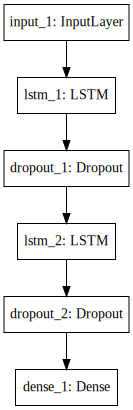

In [8]:
# Building the model
lstm_units  = 100
inputs      = Input(shape = x_train[0].shape)

layer       = LSTM(units            = lstm_units,
                   return_sequences = True,
                   activation       = 'selu')(inputs)

layer       = Dropout(0.2)(layer)

layer       = LSTM(units            = lstm_units,
                   return_sequences = False,
                   activation       = 'selu')(layer)

layer       = Dropout(0.2)(layer)

predictions = Dense(units      = 1,
                    activation = 'linear')(layer)

model       = Model(inputs, predictions)

model.compile(loss      = 'mean_squared_error',
              optimizer = 'rmsprop')

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
# Fitting the RNN to the Training set
history = model.fit(x                = x_train,
                    y                = y_train,
                    batch_size       = len(x_train),
                    epochs           = 25,
                    validation_split = 0.2,
                    verbose          = 0,
                    shuffle          = False,
                    callbacks        = [TQDMNotebookCallback()])

HBox(children=(IntProgress(value=0, description='Training', max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=200), HTML(value='')))

In [10]:
# Comparing our model's output, given the training data, to the expected output.
actual_prices_train       = sc.inverse_transform(y_train)[:-1]
predicted_BTC_price_train = sc.inverse_transform(model.predict(x_train))[1:]

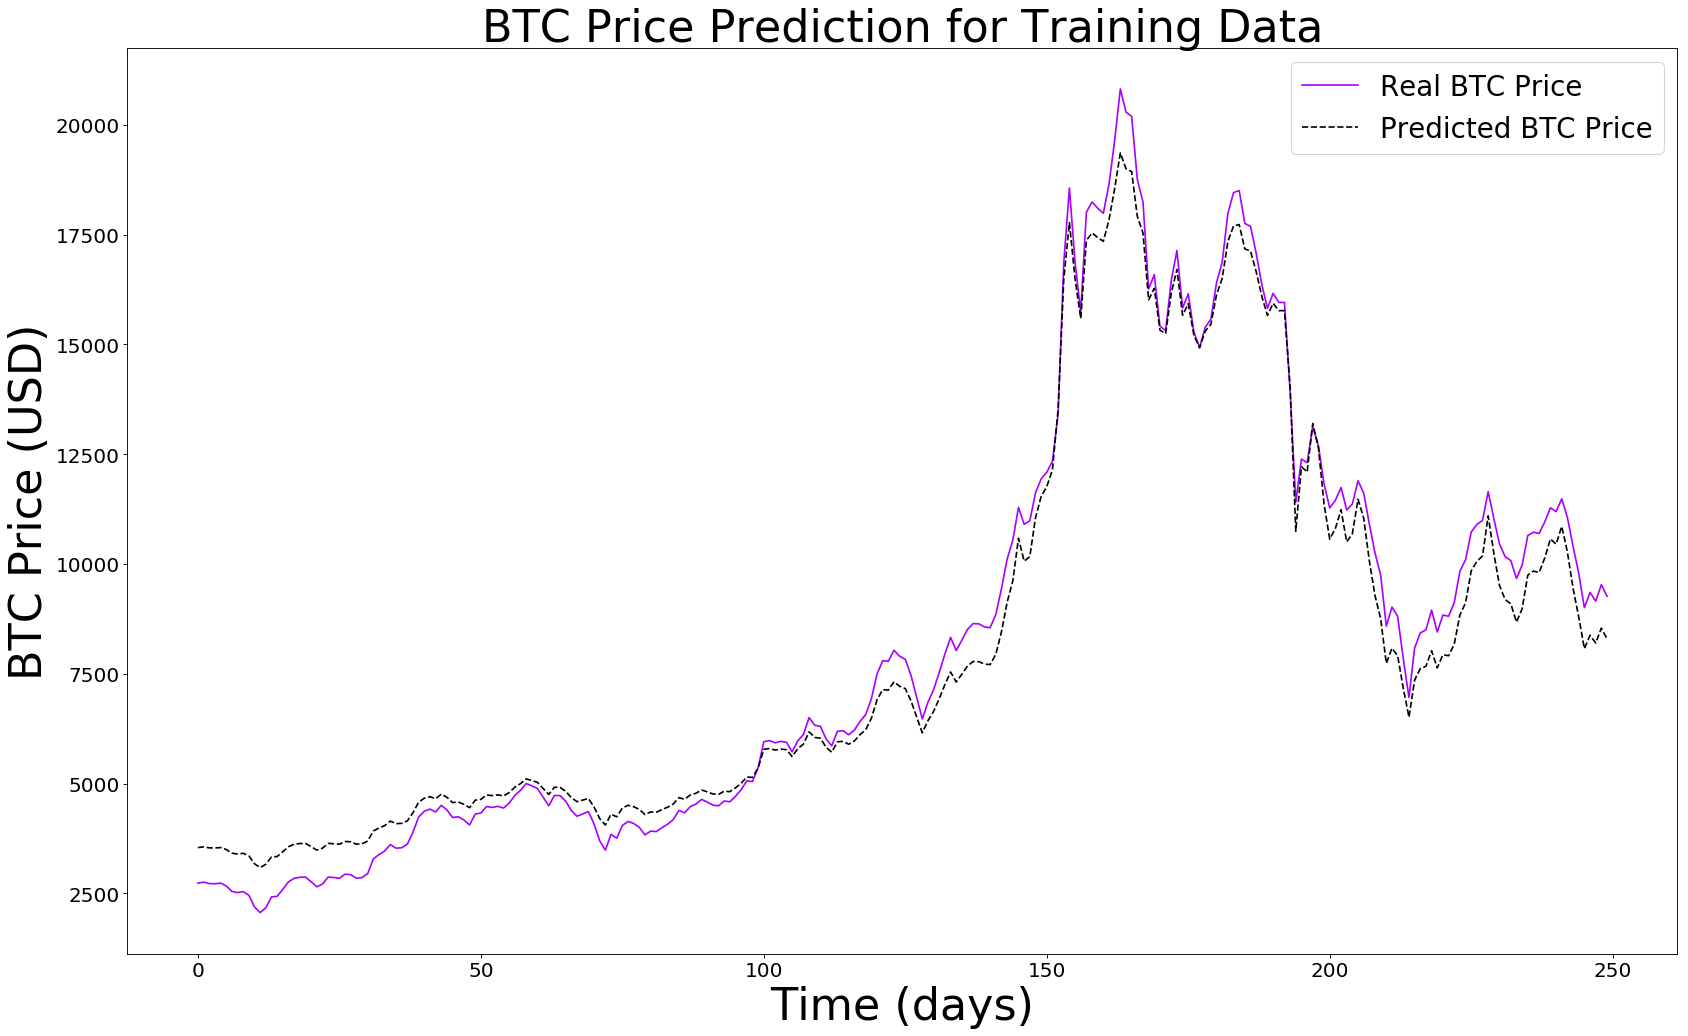

In [11]:
Plot(actual_prices_train, predicted_BTC_price_train, "BTC Price Prediction for Training Data", "Real BTC Price", "Predicted BTC Price", "BTC Price (USD)")

Even more interesting than looking at the average daily price prediction is looking at the predicted average daily price percent change as compared to that of the actual average daily price percent change; we will do this below.

In [12]:
predicted_percent_change_train = Get_Percent_Change(predicted_BTC_price_train)
actual_percent_change_train    = Get_Percent_Change(actual_prices_train)

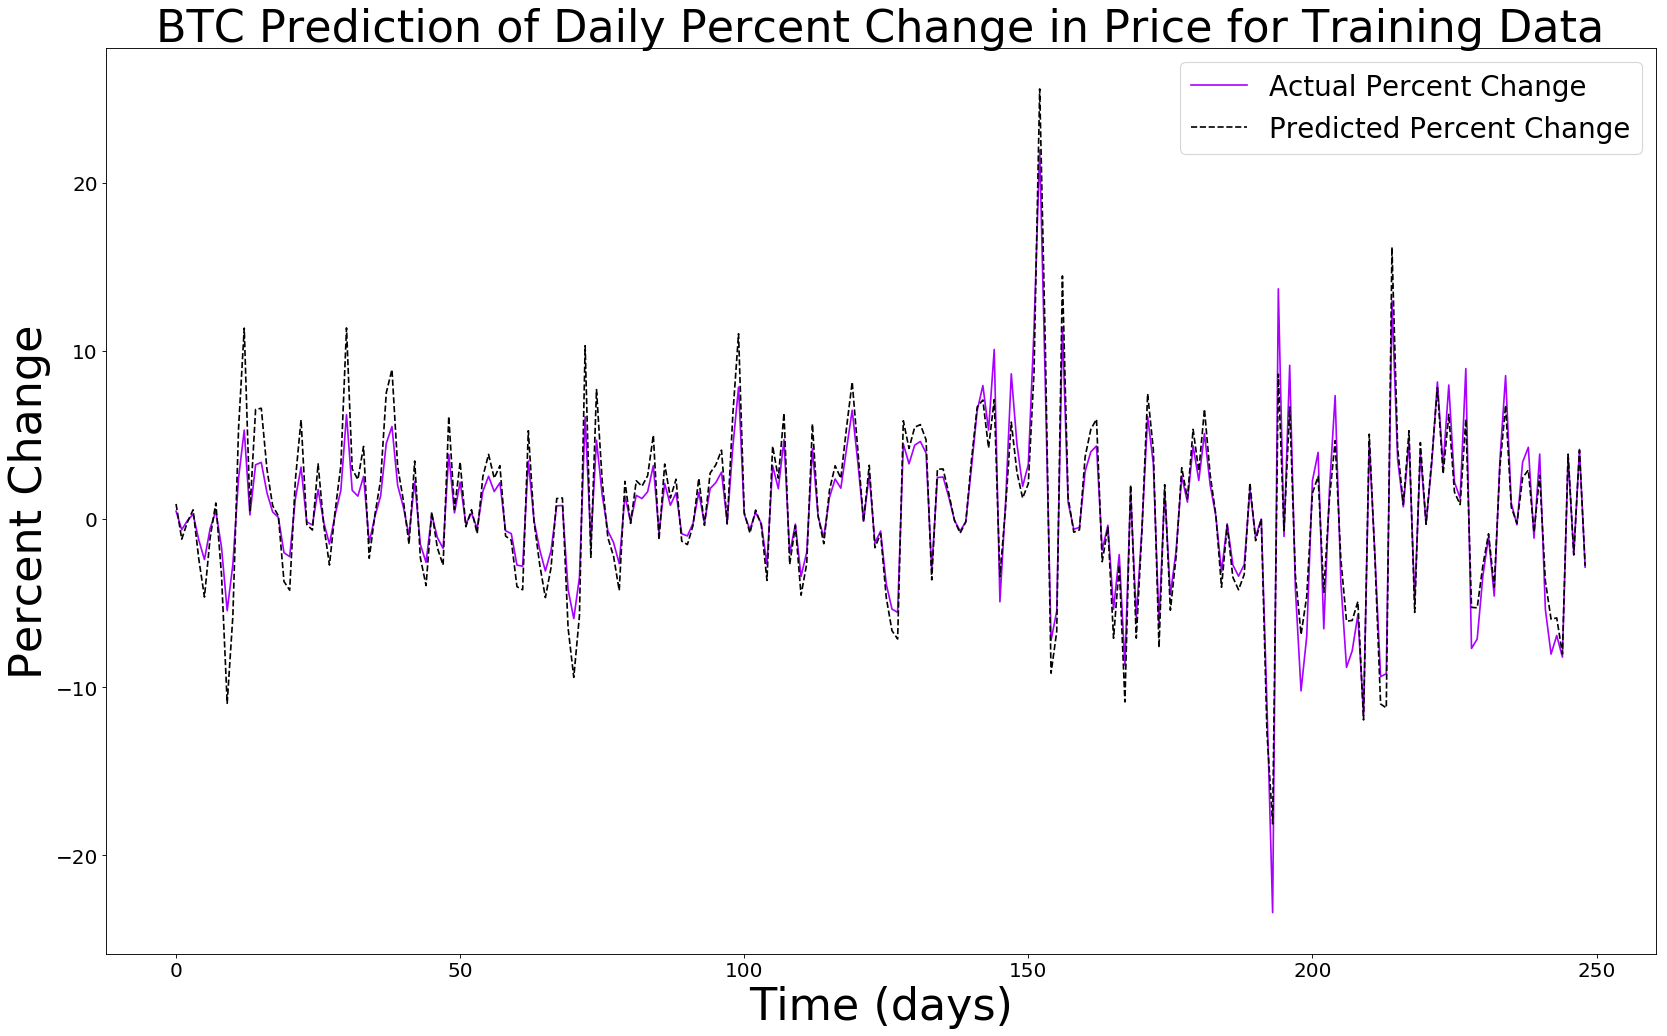

In [13]:
Plot(predicted_percent_change_train, actual_percent_change_train, "BTC Prediction of Daily Percent Change in Price for Training Data", "Actual Percent Change", "Predicted Percent Change", "Percent Change")

In [14]:
#Predicting the future.
actual_prices_test       = sc.inverse_transform(y_test)[:-1]
predicted_BTC_price_test = sc.inverse_transform(model.predict(x_test))[1:]

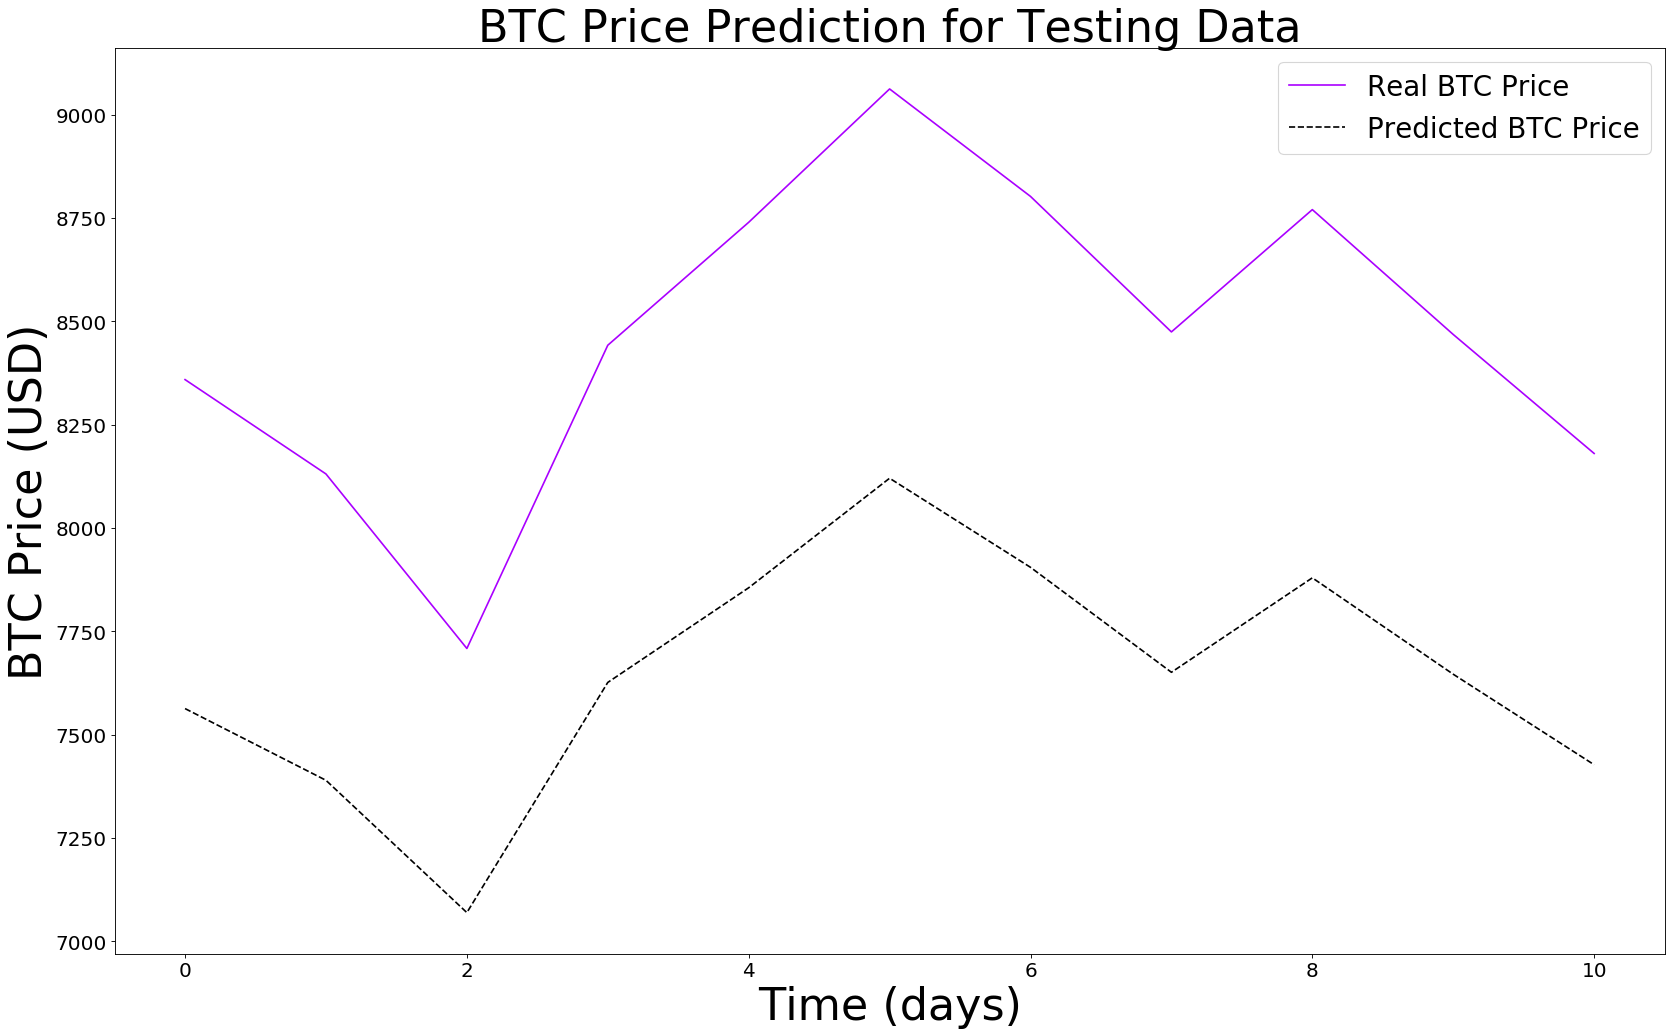

In [15]:
Plot(actual_prices_test, predicted_BTC_price_test, "BTC Price Prediction for Testing Data", "Real BTC Price", "Predicted BTC Price", "BTC Price (USD)")

In [16]:
predicted_percent_change_test = Get_Percent_Change(predicted_BTC_price_test)
actual_percent_change_test    = Get_Percent_Change(actual_prices_test)

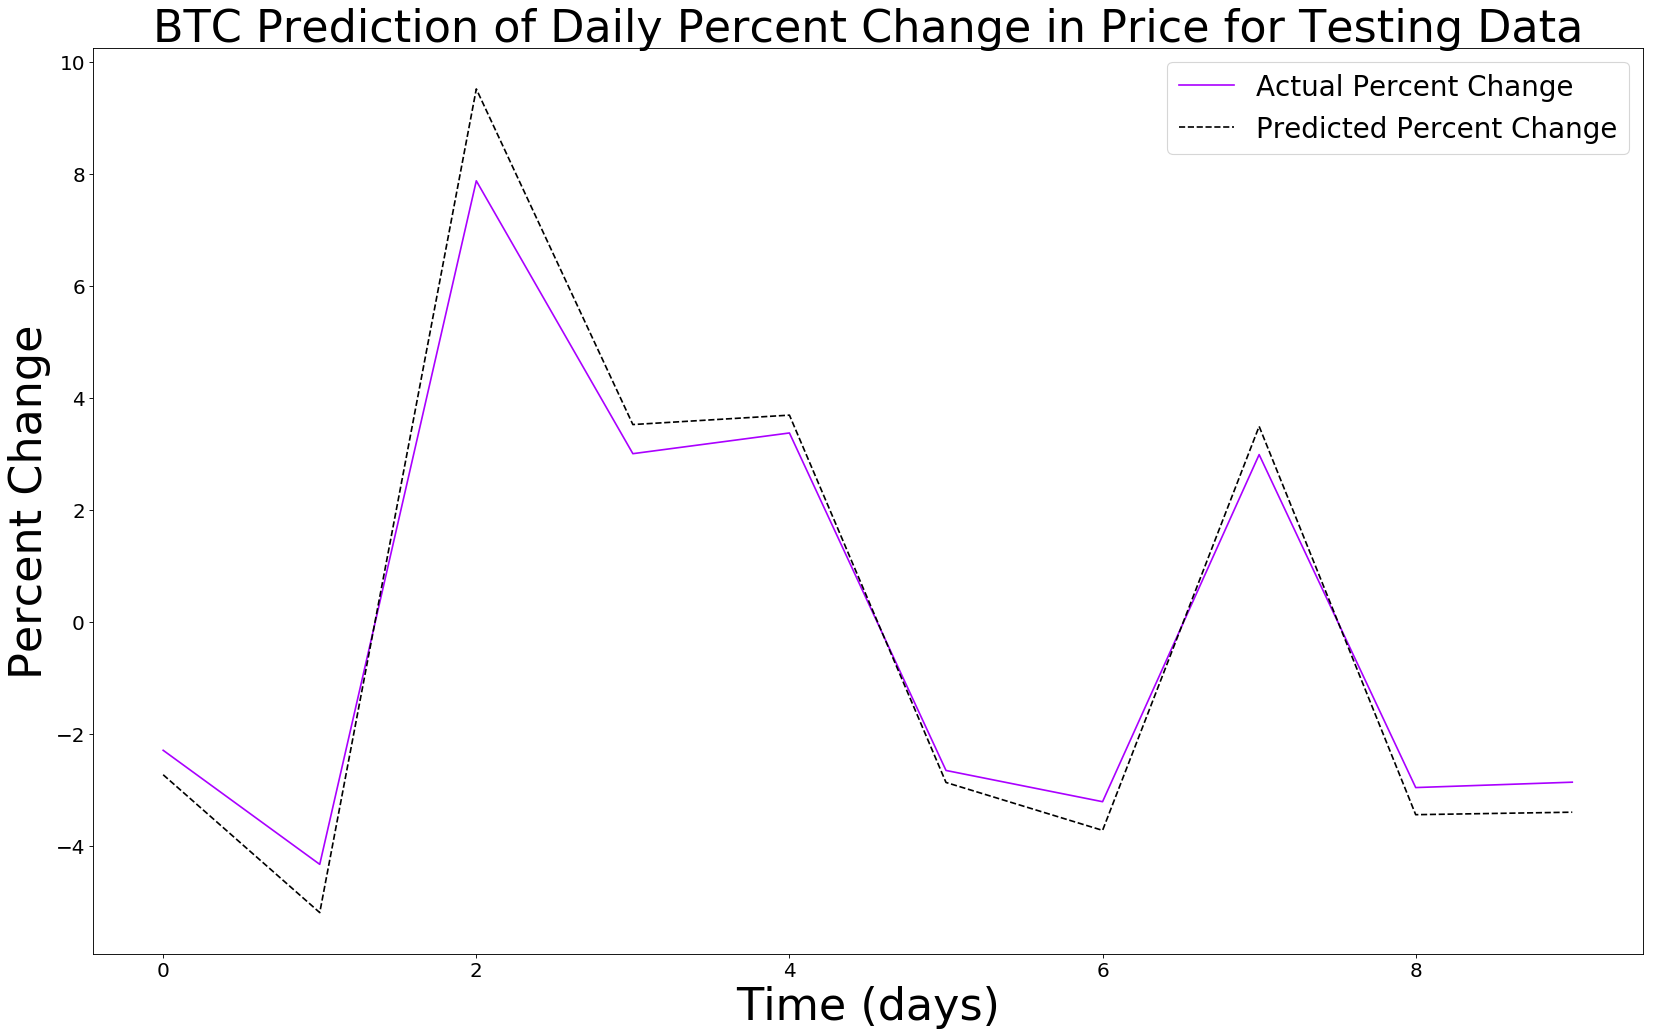

In [17]:
Plot(predicted_percent_change_test, actual_percent_change_test, "BTC Prediction of Daily Percent Change in Price for Testing Data", "Actual Percent Change", "Predicted Percent Change", "Percent Change")